# Text-based Information Retrieval

## Assignment PART II
### Using wordembedding
We can use the semantic similarity of wordembeddings, such as GloVe and Word2Vec, to obtain better results.
In this part of the exercise, we will the addition analogy (similar to Part I of this assignment) to rank the given documents.


In [1]:
# Loading modules
import os, re
import pandas as pd
from numpy import dot, sum
from gensim import matutils, models

# Set up logger that logs (works in jupyter 3!) in console and outputs in file
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='part_II_logs.log', mode='a')
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)


#### Load in word model

In [2]:
# Load Googles' pre-trained Word2Vec vector set
# Note: This will take a lot of memory and can take a while.
# Note II: Depending on your RAM, do not load all models at the same time
w2v_model = models.Word2Vec.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary=True)
#w2v_model.init_sims(replace=True) # Normalize; Trims unneeded model memory = use (much) less RAM.


INFO:gensim.models.word2vec:loading projection weights from data/GoogleNews-vectors-negative300.bin.gz
INFO:gensim.models.word2vec:loaded (3000000L, 300L) matrix from data/GoogleNews-vectors-negative300.bin.gz
INFO:gensim.models.word2vec:precomputing L2-norms of word weight vectors


In [ ]:
import smart_open
import os.path

def glove2word2vec(glove_filename):
    def get_info(glove_filename): 
        num_lines = sum(1 for line in smart_open.smart_open(glove_filename))
        dims = glove_filename.split('.')[2].split('d')[0] # file name contains the number of dimensions
        return num_lines, dims
    
    def prepend_info(infile, outfile, line): # Function to prepend lines using smart_open
        with open(infile, 'r', encoding="utf8") as original: data = original.read()
        with open(outfile, 'w', encoding="utf8") as modified: modified.write(line + '\n' + data)
        return outfile
    
    word2vec_filename = glove_filename[:-3] + "word2vec.txt"
    if os.path.isfile(word2vec_filename):
        model = models.Word2Vec.load_word2vec_format(word2vec_filename)
    else:
        num_lines, dims = get_info(glove_filename)
        gensim_first_line = "{} {}".format(num_lines, dims)
        model_file = prepend_info(glove_filename, word2vec_filename, gensim_first_line)
        model = models.Word2Vec.load_word2vec_format(model_file)
    
    model.init_sims(replace = True)  # normalize all word vectors
    return model

# Load GloVes' pre-trained model
# These vectors are stored in a plain text - vector dimensionality 50, 100, 200 and 300
# only the vectors pre-trained on Wikipedia.
glove50d_model = glove2word2vec('data/glove.6B.50d.txt')

#### Images to wordvectors

We will use the similarity of wordmodels such as Word2Vec and GloVe to make vectors of each image. These vectors will look like 
>s = w1 + w2 + ... + wn

> With s = the image vector and {w1 .. wn} the words for each image


In [4]:
# Load in a stopword list from
# http://www.lextek.com/manuals/onix/stopwords2.html
stopwords = []
with open('data/stopwordlist.txt', 'r') as f:
    lines = ''.join(f.readlines())
    stopwords = [x for x in lines.split('\n')[2:]]


In [5]:
# Translate text to avg vector
def sentence_to_vector(model, sentence):
    v1 = []
    for word in sentence.split(' '):
        try:
            v1.append(model[word])
        except:
            if "-" in word: # attempt dash removing or replacing with space
                try:
                     v1.append(model[word.replace("-", "")])
                except:
                    try:
                        v1.append(model[word.split("-")[0]])
                        v1.append(model[word.split("-")[1]])
                    except:
                        print 'word not in model:', word
                        continue
            else:
                print 'word not in model:', word
                continue
    # return matutils.unitvec(array(v1).mean(axis=0))
    return matutils.unitvec(sum(v1,axis=0))


In [40]:
# Clean input because the wordmodels can not contain every possible combination words and signs
def clean_input(text, stopwords):
    # lowecase and remove linebreaks
    text = text.lower().rstrip()
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stopwords])
    # Remove punctuation
    text = re.sub('[!@#$:;%&?,_\.\'\`\"\\\/\(\)\[\]]', '', text)
    text = re.sub('[\-]+', '-', text)
    # Remove sole numbers, dashes or extra spaces
    text = re.sub('[\s][\-]+[\s]', '', text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub('[\s]+', ' ', text)
    # British to American English - at this moment still hardcoded due to lack of library
    text = text.replace('grey', 'gray')
    text = text.replace('colour', 'color')
    text = text.replace('tyre', 'tire')
    text = text.replace('centre', 'center')
    text = text.replace('theatre', 'theater')
    text = text.replace('jewellery','jewelry')
    text = text.replace('aeroplane', 'plane')
    text = text.replace('harbour', 'harbor')
    text = text.replace('moustache','mustache')
    text = text.replace(' axe', ' hatchet')
    text = text.replace('armour', 'armor')
    text = text.replace('stylised', 'stylized')
    text = text.replace('organise', 'organize')
    text = text.replace('plough', 'plow')
    text = text.replace('neighbourhood', 'neighborhood')
    text = text.replace('vapour', 'vapor')
    # some manual fixes of lemmatizing
    text = text.replace('watersid ', 'waterside ')
    text = text.replace('figur ', 'figure ')
    text = text.replace(' graz ', ' graze ')
    text = ' '.join([word for word in text.split() if word not in stopwords])
    return text


In [16]:
# Text file parser
# Returns a dictionary with imageid - text in lowercase without stopwords or punctuation
def text_file_parser(filename, stopwords, model):
    corpus = dict()
    #corpus = pd.DataFrame(columns=('id', 'imageid', 'vec'))
    with open(filename) as f:
        next(f) # skip first line with the headings
        for doc in f:
            '''
            # Normal:
            doc_parts = doc.split('\t')
            doc_parts[2] = clean_input(doc_parts[2])
            doc_parts.append(sentence_to_vector(model, doc_parts[2]))
            corpus[doc_parts[0]] = doc_parts
            
            # If use of parsed
            '''
            # Split on spaces
            doc_parts = doc.split(" ", 1)
            # If first part is the ID (needed for the queries file)
            if(len(doc_parts[0]) < 6):
                doc_parts = doc.split(" ", 2)
                doc_parts.pop(0)
            # Clean the caption text (remove puctuation etc)
            doc_parts[1] = clean_input(doc_parts[1], stopwords)
            # Add the vector of the caption to the array
            doc_parts.append(sentence_to_vector(model, doc_parts[1]))
            # add the array (or row) to an array
            corpus[len(corpus) + 1] = doc_parts

    # Transform to dataframe
    df = pd.DataFrame.from_dict(corpus, orient='index')
    df = df.reset_index()
    df.columns = ['index', 'img_id', 'caption', 'vec']
    return df

In [41]:
# images file to docs dict
print 'Parsing documents'
training_docs = text_file_parser('data/target_collection_parsed.txt', stopwords, w2v_model)
print 'Parsing queries'
queries = text_file_parser('data/queries_val_parsed.txt', stopwords, w2v_model)

# Preview
queries

Parsing documents
word not in model: seethrough
word not in model: covington
word not in model: labcoat
word not in model: bluegreen
word not in model: figur
word not in model: solvaten
word not in model: lightyear
word not in model: black-and-white
word not in model: streetperson
word not in model: out-of-focus
word not in model: adana
word not in model: soundmixer
word not in model: tirol
word not in model: hyperthermal
word not in model: kustwacht
word not in model: tug-of-war
word not in model: black-and-white
word not in model: black-and-white
word not in model: latifah
word not in model: shepparton
word not in model: standlots
word not in model: goatram
word not in model: black-and-white
word not in model: relaxingly
word not in model: blackwhite
word not in model: black-and-white
word not in model: carmay
word not in model: jetplane
word not in model: piza
word not in model: wyclef
word not in model: tepeewith
word not in model: parke
word not in model: edwardian
word not in mod

,index,img_id,caption,vec
0,1,XBZPztvt67qkMUdI,man white shirt sit table cut meat plate front...,"[0.037023062002, 0.0189000459091, 0.0207429838..."
1,2,PaqtOaYmQmXkqW2i,woman red dress posing hatchet,"[0.0647384797321, -0.00280874662717, 0.0190497..."
2,3,IPcFtNL-7EQ6Z0yu,soccer play stand soccer ball front,"[0.00913737650506, 0.0457835407256, 0.07424217..."
3,4,IMAD0sq2Fz7HpSgX,white yellow train track,"[-0.0223426769541, 0.0784277429118, 0.04782966..."
4,5,-gqRDDfPZTGlCfJa,view tall building city,"[-0.0118529041814, 0.0563774749778, 0.01534611..."
5,6,xsrYb57vl4qiMLDG,hand pick flower vine,"[0.0556772009794, 0.0733344995993, -0.07167356..."
6,7,BCjxgJlQ3TD5T8ST,picture army ready sail,"[0.0596367267377, 0.17693899886, -0.0339552790..."
7,8,LGxwsl9CtRQ8wW3Y,brick roof house picture,"[0.0435841136776, 0.0197629527588, -0.01897175..."
8,9,9LtOvyiygFYoxU8S,man clean mess street,"[0.0964928784341, 0.1010682429, 0.050989103614..."
9,10,8usTLD-Wg5EHCShk,group kid play playground accompany adult,"[0.0110731805617, 0.00217351814068, 0.02269845..."


#### Check similarity

In [42]:
# function to calculate the similarity between 2 documents
def similarity(v1, v2):
    """
    Compute cosine similarity between two documents.
    Example:
      >>> trained_model.similarity('doc1', 'doc2')
      0.73723527
      >>> trained_model.similarity('doc2', 'doc2')
      1.0
    """
    #return dot(matutils.unitvec(v1), matutils.unitvec(v1))
    return dot(v1, v2)

In [ ]:
# CaLculate the recall for the topn results
def get_recall(topn, total_to_find, img_id, df):
    # Get the amount found for the top N results
    amount_found = float(len(df[:topn][df.img_id == img_id]))
    # Calculate recall
    return float(amount_found/total_to_find)


In [43]:
# Initialising columns in dataframe
queries['recall_10'] = 0.0
queries['recall_100'] = 0.0
queries['recall_250'] = 0.0
queries['recall_500'] = 0.0
queries['recall'] = 0.0
queries['map_10'] = 0.0 # Note: MAP (Mean Average Precision is avg per query)
queries['map_100'] = 0.0
queries['map_250'] = 0.0
queries['map_500'] = 0.0
queries['map'] = 0.0

# Calculate similarity
print "Calculating precision and recall"
for i,r in queries.iterrows():
    print "Processing query", i # Print the current query number
    
    rdoc = training_docs
    rdoc["sim"] = 0.0
    # Calculate similarity per vector document
    for index, row in rdoc.iterrows():
        sim = similarity(r['vec'], row['vec'])
        rdoc.set_value(index, "sim", sim)
    # order by similarity
    rdoc = rdoc.sort_values(by=['sim'], ascending=[0])
    rdoc.drop_duplicates(subset=['img_id'])
    # cut at top 1000 results
    rdoc = rdoc[:1000]
    
    # Recall 10,100,250,500,1000
    total_to_find = float(len(training_docs[training_docs.img_id == r['img_id']]))
    queries.set_value(i, 'recall_10', get_recall(10, total_to_find, r['img_id'], rdoc))
    queries.set_value(i, 'recall_100', get_recall(100, total_to_find, r['img_id'], rdoc))
    queries.set_value(i, 'recall_250', get_recall(250, total_to_find, r['img_id'], rdoc))
    queries.set_value(i, 'recall_500', get_recall(500, total_to_find, r['img_id'], rdoc))
    queries.set_value(i, 'recall', get_recall(1000, total_to_find, r['img_id'], rdoc))
    
    # Mean Average Precision (MAP)
    #precision = float(amount_found/float(1000))
    #queries.set_value(i, 'precision', precision)
    rdoc = rdoc.reset_index() # reset index so 1 = position 1 etc
    avg_precision = 0.0
    curr_found = 0.0
    for index,row in rdoc.iterrows():
        if row['img_id'] == r['img_id']:
            curr_found = curr_found + 1.0
        current_ap = curr_found/float(index + 1.0)
        avg_precision = float(avg_precision + current_ap)
        if index == 9:
            queries.set_value(i, 'map_10', float(avg_precision/10.0))
        if index == 99:
            queries.set_value(i, 'map_100', float(avg_precision/100.0))
        if index == 249:
            queries.set_value(i, 'map_250', float(avg_precision/250.0))
        if index == 499:
            queries.set_value(i, 'map_500', float(avg_precision/500.0))

    avg_precision = avg_precision/1000
    queries.set_value(i, 'map', avg_precision)


Calculating precision and recall


#### Results

In [48]:
print "Displaying results:"

# Remove irrelevant columns
queries = queries.drop('caption', 1)
queries = queries.drop('vec', 1)
queries = queries.drop('index', 1)

# Save results
queries.to_csv(path_or_buf='data/results.csv')

print "--"
print "MAP for best 10:", queries['map_10'].mean()
print "MAP for best 100:", queries['map_100'].mean()
print "MAP for best 250:", queries['map_250'].mean()
print "MAP for best 500:", queries['map_500'].mean()
print "MAP for best 1000:", queries['map'].mean()

print "AVG recall for best 10", queries.recall_10.mean()
print "AVG recall for best 100", queries.recall_100.mean()
print "AVG recall for best 250", queries.recall_250.mean()
print "AVG recall for best 500", queries.recall_500.mean()
print "AVG recall for best 1000", queries.recall.mean()
print "--"

# print results
print queries



Displaying results:
--
AVG recall 0.761732114568
AVG precision: 0.00880808080808
--
              img_id    recall  precision
0   XBZPztvt67qkMUdI  0.166667      0.001
1   PaqtOaYmQmXkqW2i  0.250000      0.002
2   IPcFtNL-7EQ6Z0yu  1.000000      0.005
3   IMAD0sq2Fz7HpSgX  1.000000      0.005
4   -gqRDDfPZTGlCfJa  0.785714      0.033
5   xsrYb57vl4qiMLDG  1.000000      0.004
6   BCjxgJlQ3TD5T8ST  0.800000      0.004
7   LGxwsl9CtRQ8wW3Y  1.000000      0.006
8   9LtOvyiygFYoxU8S  1.000000      0.006
9   8usTLD-Wg5EHCShk  1.000000      0.005
10  kH59MJp3nWyFfFB2  0.666667      0.006
11  tluPF-CA6dN6LACF  0.833333      0.005
12  HKXYBXXObkt_yi7s  1.000000      0.006
13  mBJjuuB0ukfKmnRH  1.000000      0.006
14  cqpTaVCZZe5OpuIk  0.875000      0.007
15  Anry0qU5NFes6Twh  1.000000      0.008
16  ByjuNEqsLcbUk5OH  0.714286      0.005
17  5dBiwoDEpY6gWRek  0.897436      0.035
18  ZFdHuWXCk662UDAW  0.600000      0.003
19  BqoajT5F2iTYrBVY  0.833333      0.005
20  6e3OOBOz0U2yUPw2  0.611111    

### Results from calculations on server
For lowering the workload on our computers, we let a server do the calculations and write the results to a csv file.


In [5]:
# Read in results file
df = pd.DataFrame.from_csv('results/results.csv')

# averages
print "--"
print "MAP for best 10:", df['map_10'].mean()
print "MAP for best 100:", df['map_100'].mean()
print "MAP for best 250:", df['map_250'].mean()
print "MAP for best 500:", df['map_500'].mean()
print "MAP for best 1000:", df['map'].mean()

print "AVG recall for best 10", df.recall_10.mean()
print "AVG recall for best 100", df.recall_100.mean()
print "AVG recall for best 250", df.recall_250.mean()
print "AVG recall for best 500", df.recall_500.mean()
print "AVG recall for best 1000", df.recall.mean()
print "--"

# Preview dataframe
df

--
AVG recall 0.80570506732
AVG precision: 0.0101311311311
MAP precision: 0.0335527047292
--


,img_id,recall,precision,map
0,XBZPztvt67qkMUdI,0.166667,0.001,0.002681
1,PaqtOaYmQmXkqW2i,0.625000,0.005,0.006035
2,IPcFtNL-7EQ6Z0yu,1.000000,0.005,0.018102
3,IMAD0sq2Fz7HpSgX,1.000000,0.005,0.030165
4,-gqRDDfPZTGlCfJa,0.857143,0.036,0.090461
5,xsrYb57vl4qiMLDG,1.000000,0.004,0.021364
6,BCjxgJlQ3TD5T8ST,0.800000,0.004,0.009853
7,LGxwsl9CtRQ8wW3Y,1.000000,0.006,0.014346
8,9LtOvyiygFYoxU8S,1.000000,0.006,0.021698
9,8usTLD-Wg5EHCShk,1.000000,0.005,0.026923


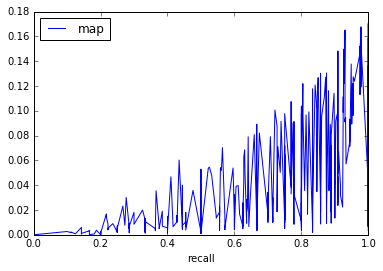

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# Sort by recall
df = df.sort_values(by=['recall'], ascending=[1])

# Show and save chart
qx = df.plot(x='recall', y='map')
fig = qx.get_figure()
fig.savefig('results/part2_embedding_precision-recall.png')